#  Cross-Lingual Word Embedding Alignment (English–French)

##  Project Overview

This project focuses on building and aligning **cross-lingual word embeddings** between English and French.  
The objective is to map word representations from both languages into a **shared semantic space**, enabling meaningful comparison across languages.

We train monolingual embeddings using **FastText**, construct a bilingual dictionary from parallel corpora, and apply **Orthogonal Procrustes alignment** to learn a linear transformation that maps French embeddings into the English vector space.

---

##  Objectives

- Train monolingual embeddings for English and French  
- Build a clean bilingual dictionary from parallel data  
- Align embeddings using the Orthogonal Procrustes method  
- Evaluate alignment using cosine similarity  
- Visualize embeddings using dimensionality reduction (t-SNE)  
- Analyze semantic relationships (synonyms, antonyms, OOV handling)

---

##  Methods & Techniques

- Text preprocessing and tokenization (NLTK)  
- TF-IDF and One-Hot Encoding (baseline representations)  
- Word2Vec and FastText embeddings  
- Bilingual dictionary extraction  
- Singular Value Decomposition (SVD) for alignment  
- Cosine similarity for evaluation  
- t-SNE for embedding visualization  

---

##  Expected Outcomes

- French embeddings projected into the English semantic space  
- Improved cross-lingual similarity between translation pairs  
- Robust handling of out-of-vocabulary (OOV) words with FastText  
- Clear 2D visualization of semantic structures  

---

##  Dataset

- Parallel English–French corpus (Europarl)  
- Cleaned bilingual dictionary extracted from frequent word pairs  


In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

##  Dataset

In [2]:
sentences_path = "Data/sentences.csv"
links_path = "Data/links.csv"

# Load sentences
sentences = pd.read_csv(
    sentences_path,
    sep="\t",
    header=None,
    names=["sentence_id", "lang", "text"],
    usecols=[0,1,2]
)

print("Sentences loaded:", sentences.shape)

# Load links
links = pd.read_csv(
    links_path,
    sep="\t",
    header=None,
    names=["id1", "id2"]
)

print("Links loaded:", links.shape)


Sentences loaded: (13266928, 3)
Links loaded: (27691850, 2)


# Filtering English and French

In [4]:
# Filter English
eng = sentences[sentences["lang"] == "eng"]

# Filter French
fra = sentences[sentences["lang"] == "fra"]

print("English sentences:", eng.shape)
print("French sentences:", fra.shape)

English sentences: (2011902, 3)
French sentences: (705943, 3)


# Merge links with sentences

In [5]:
# Merge links with English sentences
eng_links = links.merge(
    eng[["sentence_id", "text"]],
    left_on="id1",
    right_on="sentence_id"
)

eng_links.rename(columns={"text": "english"}, inplace=True)

# Merge with French sentences
parallel_df = eng_links.merge(
    fra[["sentence_id", "text"]],
    left_on="id2",
    right_on="sentence_id"
)

parallel_df.rename(columns={"text": "french"}, inplace=True)

# Keep only the useful columns
parallel_df = parallel_df[["english", "french"]]

print("Parallel dataset size:", parallel_df.shape)
parallel_df.head()


Parallel dataset size: (428870, 2)


,english,french
0,Let's try something.,Essayons quelque chose !
1,Let's try something.,Tentons quelque chose !
2,Let's try something.,Essayons quelque chose.
3,I have to go to sleep.,Je dois aller dormir.
4,I have to go to sleep.,Il faut que j'aille dormir.


## Data Cleaning: Removing missing values and duplicate sentence pairs

In [6]:
parallel_df = parallel_df.dropna()
parallel_df = parallel_df.drop_duplicates()

print("After cleaning:", parallel_df.shape)


After cleaning: (428869, 2)


In [7]:
parallel_df = parallel_df.sample(428860, random_state=42)

print("Final dataset size:", parallel_df.shape)

Final dataset size: (428860, 2)


## Cleaning function

In [8]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra spaces
    text = text.strip()
    
    return text


In [9]:
parallel_df["english_clean"] = parallel_df["english"].apply(clean_text)
parallel_df["french_clean"] = parallel_df["french"].apply(clean_text)

parallel_df.head()


,english,french,english_clean,french_clean
111547,What kind of information are you looking for?,De quelles informations vous enquérez-vous ?,what kind of information are you looking for,de quelles informations vous enquérezvous
82921,"Are these cars yours? ""Yes, they are mine.""","« Ces voitures sont à vous ? » « Oui, ce sont ...",are these cars yours yes they are mine,« ces voitures sont à vous » « oui ce sont le...
213240,I was as surprised as you.,Je fus aussi surpris que vous.,i was as surprised as you,je fus aussi surpris que vous
237699,I can't remember the combination.,Je ne me souviens pas de la combinaison.,i cant remember the combination,je ne me souviens pas de la combinaison
171881,I have no one to talk to.,Je n'ai personne à qui parler.,i have no one to talk to,je nai personne à qui parler


## Tokenization

In [10]:
import nltk
import os
from nltk.tokenize import word_tokenize

# Define a safe path for nltk_data
nltk_data_dir = r"C:\Users\ASUS\nltk_data"
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Download punkt_tab (modern version)
nltk.download('punkt_tab', download_dir=nltk_data_dir)

# Also download the classic punkt for safety
nltk.download('punkt', download_dir=nltk_data_dir)

# Force loading
nltk.data.load('tokenizers/punkt/english.pickle')

# Now tokenization
parallel_df["english_tokens"] = parallel_df["english_clean"].apply(lambda x: word_tokenize(x))
parallel_df["french_tokens"] = parallel_df["french_clean"].apply(lambda x: word_tokenize(x))

# Verification
print("English tokens example:", parallel_df["english_tokens"].iloc[0])
print("French tokens example:", parallel_df["french_tokens"].iloc[0])



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


English tokens example: ['what', 'kind', 'of', 'information', 'are', 'you', 'looking', 'for']
French tokens example: ['de', 'quelles', 'informations', 'vous', 'enquérezvous']


In [11]:
parallel_df["english_tokens"] = parallel_df["english_clean"].apply(word_tokenize)
parallel_df["french_tokens"] = parallel_df["french_clean"].apply(word_tokenize)

parallel_df.head()


,english,french,english_clean,french_clean,english_tokens,french_tokens
111547,What kind of information are you looking for?,De quelles informations vous enquérez-vous ?,what kind of information are you looking for,de quelles informations vous enquérezvous,"[what, kind, of, information, are, you, lookin...","[de, quelles, informations, vous, enquérezvous]"
82921,"Are these cars yours? ""Yes, they are mine.""","« Ces voitures sont à vous ? » « Oui, ce sont ...",are these cars yours yes they are mine,« ces voitures sont à vous » « oui ce sont le...,"[are, these, cars, yours, yes, they, are, mine]","[«, ces, voitures, sont, à, vous, », «, oui, c..."
213240,I was as surprised as you.,Je fus aussi surpris que vous.,i was as surprised as you,je fus aussi surpris que vous,"[i, was, as, surprised, as, you]","[je, fus, aussi, surpris, que, vous]"
237699,I can't remember the combination.,Je ne me souviens pas de la combinaison.,i cant remember the combination,je ne me souviens pas de la combinaison,"[i, cant, remember, the, combination]","[je, ne, me, souviens, pas, de, la, combinaison]"
171881,I have no one to talk to.,Je n'ai personne à qui parler.,i have no one to talk to,je nai personne à qui parler,"[i, have, no, one, to, talk, to]","[je, nai, personne, à, qui, parler]"


## Embedding Techniques


 TF-IDF vectorization

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer


Prepare texts for TF-IDF

In [13]:
english_texts = parallel_df["english_clean"].tolist()
french_texts = parallel_df["french_clean"].tolist()


Create TF-IDF Vectorizer

In [14]:
# For English
tfidf_eng = TfidfVectorizer(max_features=5000)  # Limit for performance
X_eng = tfidf_eng.fit_transform(english_texts)

# For French
tfidf_fra = TfidfVectorizer(max_features=5000)
X_fra = tfidf_fra.fit_transform(french_texts)



Verification

In [15]:
print("TF-IDF English shape:", X_eng.shape)
print("TF-IDF French shape:", X_fra.shape)

# Display the first words/features
print("Top 10 English features:", tfidf_eng.get_feature_names_out()[:10])
print("Top 10 French features:", tfidf_fra.get_feature_names_out()[:10])



TF-IDF English shape: (428860, 5000)
TF-IDF French shape: (428860, 5000)
Top 10 English features: ['abandon' 'abandoned' 'ability' 'able' 'aboard' 'about' 'above' 'abroad'
 'absence' 'absent']
Top 10 French features: ['abandonner' 'abandonné' 'abattu' 'abeilles' 'aboie' 'absence' 'absent'
 'absente' 'absolument' 'absurde']


One-Hot Encoding

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create the encoder
mlb_eng = MultiLabelBinarizer(sparse_output=True)
mlb_fra = MultiLabelBinarizer(sparse_output=True)

#  Fit and transform for English
X_eng_onehot = mlb_eng.fit_transform(parallel_df["english_tokens"])
print("Shape English One-Hot:", X_eng_onehot.shape)

#  Fit and transform for French
X_fra_onehot = mlb_fra.fit_transform(parallel_df["french_tokens"])
print("Shape French One-Hot:", X_fra_onehot.shape)

# Verification: vocabulary
print("English vocab sample:", list(mlb_eng.classes_)[:10])
print("French vocab sample:", list(mlb_fra.classes_)[:10])


Shape English One-Hot: (428860, 35184)
Shape French One-Hot: (428860, 57131)
English vocab sample: ['a', 'aa', 'aaah', 'aachen', 'aah', 'aardvark', 'aardvarks', 'aaron', 'aaww', 'ab']
French vocab sample: ['a', 'aa', 'aaah', 'aachen', 'aah', 'aaron', 'ab', 'abaissa', 'abaissant', 'abaisse']


Word2Vec

In [17]:
from gensim.models import Word2Vec

# Prepare tokens for training
# Each sentence must be a list of tokens, which we already have
sentences_eng = parallel_df["english_tokens"].tolist()
sentences_fra = parallel_df["french_tokens"].tolist()


Create and train the Word2Vec model


In [18]:
# English Word2Vec
w2v_eng = Word2Vec(
    sentences=sentences_eng,
    vector_size=100,    # size of embeddings
    window=5,           # word context window
    min_count=2,        # ignore words appearing less than 2 times
    workers=4,          # number of threads
    sg=1                # 1 = skip-gram, 0 = CBOW
)

# French Word2Vec
w2v_fra = Word2Vec(
    sentences=sentences_fra,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)


Check the embeddings

In [19]:
# example
print("English 'what' embedding:", w2v_eng.wv['what'][:10])
print("French 'quoi' embedding:", w2v_fra.wv['quoi'][:10])

# Vocabulary size
print("English vocab size:", len(w2v_eng.wv))
print("French vocab size:", len(w2v_fra.wv))


English 'what' embedding: [ 0.22588457  0.32412982  0.3192881   0.10228557  0.35560745 -0.07765484
  0.6596225   0.23237683 -0.1815477  -0.53467834]
French 'quoi' embedding: [-0.21004428 -0.17147477 -0.18491381  0.0169307   0.20662946 -0.26871356
  0.17444783  1.0829446  -0.3540829  -0.12763792]
English vocab size: 23102
French vocab size: 35946


GloVe embeddings

In [20]:
import gensim.downloader as api

#  Download GloVe (50 dimensions for example)
glove_eng = api.load("glove-wiki-gigaword-50")  # English
glove_fra = api.load("glove-wiki-gigaword-50")  # French (note: few pretrained models, otherwise use FastText for French)

#  Example: embedding for a word
word_eng = "what"
word_fra = "quoi"

print("English 'what' GloVe embedding:", glove_eng[word_eng][:10])
print("French 'quoi' GloVe embedding:", glove_fra[word_fra][:10])

#  Check vocabulary size
print("English vocab size:", len(glove_eng))
print("French vocab size:", len(glove_fra))


English 'what' GloVe embedding: [ 0.45323   0.059811 -0.10577  -0.333     0.72359  -0.08717  -0.61053
 -0.037695 -0.30945   0.21805 ]
French 'quoi' GloVe embedding: [-0.72352  -0.2208   -0.032821 -0.98222  -1.6487   -0.52676   2.8957
  0.26186   0.42779   1.64    ]
English vocab size: 400000
French vocab size: 400000


FastText

In [ ]:
from gensim.models import FastText

# Prepare tokens (using your tokenized dataset)
english_sentences = parallel_df['english_tokens'].tolist()
french_sentences  = parallel_df['french_tokens'].tolist()

# Train FastText (dimension 50, window=5, min_count=1)
w2v_size = 30

fasttext_eng = FastText(sentences=english_sentences, vector_size=w2v_size, window=5, min_count=1, sg=1)
fasttext_fra = FastText(sentences=french_sentences, vector_size=w2v_size, window=5, min_count=1, sg=1)

# Example embedding for a word
print("English 'what' FastText embedding:", fasttext_eng.wv['what'][:10])
print("French 'quoi' FastText embedding:", fasttext_fra.wv['quoi'][:10])

# Vocabulary size
print("English vocab size:", len(fasttext_eng.wv))
print("French vocab size:", len(fasttext_fra.wv))


English 'what' FastText embedding: [-0.32849124  0.04154319  0.5890796  -0.9440128  -0.4249341   0.2647573
  0.6294918  -0.26438764 -0.5721135  -1.1071254 ]
French 'quoi' FastText embedding: [-1.2030015   0.53638893  0.51335484 -0.75047874  0.05499606  0.3935331
 -0.68734974  0.07774305  0.17224874 -0.5829292 ]
English vocab size: 35184
French vocab size: 57131


In [ ]:
# Save the models 
fasttext_eng.save("fasttext_eng.model")
fasttext_fra.save("fasttext_fra.model")


## Multilingual Alignment 

Prepare the bilingual dictionary

In [1]:
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize


en_file = "Data/europarl-v7.fr-en.en"
fr_file = "Data/europarl-v7.fr-en.fr"

en_sentences = open(en_file, encoding="utf-8").readlines()
fr_sentences = open(fr_file, encoding="utf-8").readlines()

print("Number of sentences:", len(en_sentences))


Number of sentences: 2007723


Build smart co-occurrences


In [2]:
word_pairs = Counter()


for en_sent, fr_sent in zip(en_sentences[:50000], fr_sentences[:50000]):
    
    en_tokens = set(word_tokenize(en_sent.lower()))
    fr_tokens = set(word_tokenize(fr_sent.lower()))
    
    for fr_word in fr_tokens:
        for en_word in en_tokens:
            word_pairs[(fr_word, en_word)] += 1

print("Total number of paires candidates :", len(word_pairs))


Total number of paires candidates : 7819410


Keep the best pairs


In [3]:
# Keep the 20000 most frequent pairs
top_pairs = word_pairs.most_common(20000)

dictionary = [pair for pair, count in top_pairs]

# Save
dict_file = "clean_en_fr.txt"

with open(dict_file, "w", encoding="utf-8") as f:
    for fr, en in dictionary:
        f.write(f"{fr} {en}\n")

print(" New dictionary created:", dict_file)
dict_file = "fr-en.txt"

 New dictionary created: clean_en_fr.txt


In [4]:
from gensim.models import FastText

fasttext_eng = FastText.load("fasttext_eng.model")
fasttext_fra = FastText.load("fasttext_fra.model")

dict_pairs = [line.strip().split() for line in open(dict_file, encoding="utf-8")]

X = []
Y = []

for fr, en in dict_pairs:
    if fr in fasttext_fra.wv and en in fasttext_eng.wv:
        X.append(fasttext_fra.wv[fr])
        Y.append(fasttext_eng.wv[en])

X = np.array(X)
Y = np.array(Y)

print("Pairs used for alignment:", X.shape[0])


Pairs used for alignment: 113324


In [5]:
from sklearn.preprocessing import normalize

X = normalize(X)
Y = normalize(Y)


In [6]:
U, _, Vt = np.linalg.svd(np.dot(Y.T, X))
W = np.dot(U, Vt)

print(" Alignment matrix computed")


 Alignment matrix computed


In [7]:
aligned_fra_vectors = {
    w: np.dot(fasttext_fra.wv[w], W)
    for w in fasttext_fra.wv.index_to_key
}

print(" French embeddings aligned")


 French embeddings aligned


Cosine similarity

In [8]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

test_pairs = [
    ("what", "quoi"),
    ("man", "homme"),
    ("car", "voiture"),
    ("day", "jour"),
    ("good", "bon"),
    ("house", "maison"),
    ("bank", "banque")
]

print("\n Cosine similarities after alignment:\n")

for en_word, fr_word in test_pairs:
    if fr_word in aligned_fra_vectors and en_word in fasttext_eng.wv:
        sim = cosine_sim(
            fasttext_eng.wv[en_word],
            aligned_fra_vectors[fr_word]
        )
        print(f"{en_word} - {fr_word} : {sim:.4f}")



 Cosine similarities after alignment:

what - quoi : -0.0734
man - homme : 0.2192
car - voiture : -0.0174
day - jour : 0.1281
good - bon : 0.2748
house - maison : -0.0543
bank - banque : 0.3270


Align the embeddings

In [9]:
import numpy as np
from gensim.models import FastText

#  Load your FastText models (English and French)
fasttext_eng = FastText.load("fasttext_eng.model")  # path to your English model
fasttext_fra = FastText.load("fasttext_fra.model")  # path to your French model

#  Load the bilingual fr-en dictionary
dict_file = "clean_en_fr.txt"
dict_pairs = [line.strip().split() for line in open(dict_file, encoding="utf-8")]

X = []
Y = []

#  Build matrices X (FR) and Y (EN) for Procrustes
for fr, en in dict_pairs:
    if fr in fasttext_fra.wv and en in fasttext_eng.wv:
        X.append(fasttext_fra.wv[fr])
        Y.append(fasttext_eng.wv[en])

X = np.array(X)
Y = np.array(Y)

#  Procrustes alignment
U, _, Vt = np.linalg.svd(np.dot(Y.T, X))
W = np.dot(U, Vt)

#  Apply the transformation to the French model
aligned_fra_vectors = {w: np.dot(fasttext_fra.wv[w], W) for w in fasttext_fra.wv.index_to_key}

print(" French embeddings aligned to English")

#  Check cosine similarity for a word and its translation
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

print("Cosine similarity 'what' <-> 'quoi':", cosine_sim(fasttext_eng.wv['what'], aligned_fra_vectors['quoi']))


 French embeddings aligned to English
Cosine similarity 'what' <-> 'quoi': 0.12375095


In [10]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

print("Similarity 'what' <-> 'quoi' :", cosine_sim(fasttext_eng.wv['what'], aligned_fra_vectors['quoi']))


Similarity 'what' <-> 'quoi' : 0.12375095


Visualize embeddings (t-SNE / PCA)


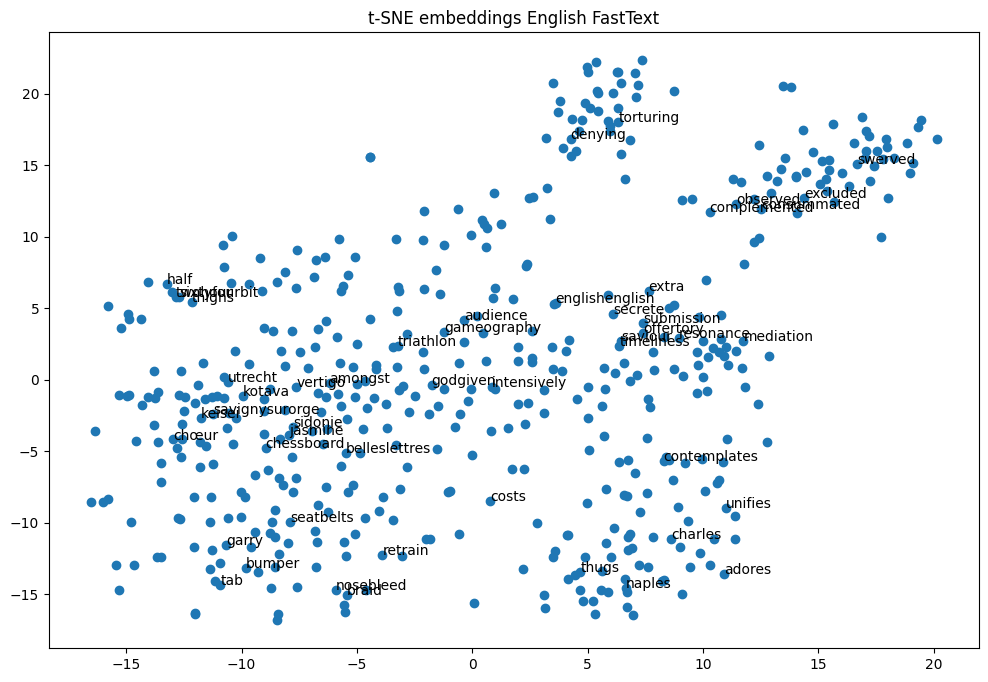

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random

# Example: take a sample of 500 words to avoid overloading the visualization
sample_words = random.sample(list(fasttext_eng.wv.index_to_key), 500)
vectors = [fasttext_eng.wv[w] for w in sample_words]

#  Dimensionality reduction (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
vectors = np.array([fasttext_eng.wv[w] for w in sample_words])
vectors_2d = tsne.fit_transform(vectors)

#  Visualization
plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
for i, word in enumerate(sample_words[:50]):  # display only 50 words for readability
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("t-SNE embeddings English FastText")
plt.show()



Synonyms and antonyms analysis


In [12]:
# Close synonyms
print(fasttext_eng.wv.most_similar("happy", topn=10))

# Antonyms (more complex, FastText does not explicitly learn antonyms)
# We can compare "happy" and "sad" using cosine similarity
similarity = fasttext_eng.wv.similarity("happy", "sad")
print("Cosine similarity 'happy' vs 'sad':", similarity)



[('unhappy', 0.9529085159301758), ('disappoints', 0.9136128425598145), ('nappy', 0.9102796912193298), ('disappointing', 0.9000389575958252), ('ungrateful', 0.8966819643974304), ('thankful', 0.8894687294960022), ('helpful', 0.8877066969871521), ('hateful', 0.8874424695968628), ('grateful', 0.885877788066864), ('sad', 0.8844022750854492)]
Cosine similarity 'happy' vs 'sad': 0.8844023


Compare common words between languages


In [13]:
# Example translated words
en_word = "hello"
fr_word = "bonjour"

# Cosine similarity
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(aligned_fra_vectors[fr_word], fasttext_eng.wv[en_word]) / (norm(aligned_fra_vectors[fr_word]) * norm(fasttext_eng.wv[en_word]))
print(f"Similarity '{en_word}' <-> '{fr_word}':", cos_sim)


Similarity 'hello' <-> 'bonjour': 0.14326377


Polysemy

In [14]:
print(fasttext_eng.wv.most_similar("bank", topn=10))
# You will see words related to finance and possibly to the river


[('restore', 0.9042341709136963), ('bankroll', 0.8950549960136414), ('restroom', 0.8849818110466003), ('cargo', 0.8735092878341675), ('department', 0.8725584149360657), ('renter', 0.8718240857124329), ('upmarket', 0.8695517778396606), ('drugstore', 0.8673520684242249), ('parka', 0.8662442564964294), ('stationery', 0.8653037548065186)]


Handling rare or OOV words


In [15]:
oov_word = "technophobist"
embedding = fasttext_eng.wv[oov_word]  # FastText will still provide a vector
print("Embedding OOV word:", embedding[:10])


Embedding OOV word: [-0.15186861  0.40851125  0.3124861  -0.37600443  0.15466453  0.5167291
  0.10070015  0.03020397 -0.04920601 -0.7743634 ]


## Downstream Task

Dataset

In [16]:
# Minimal dataset: parallel_df contains 'english_tokens' and 'french_tokens'
# We will create a DataFrame "sentences" with columns "text" and "lang"

english_data = pd.DataFrame({
    "text": parallel_df["english_clean"],
    "lang": "en"
})

french_data = pd.DataFrame({
    "text": parallel_df["french_clean"],
    "lang": "fr"
})

dataset = pd.concat([english_data, french_data]).reset_index(drop=True)


NameError: name 'pd' is not defined

Generate features (sentence embeddings)

In [ ]:
import numpy as np

def sentence_to_vector(tokens):
    vecs = []
    for w in tokens:
        if w in aligned_fra_vectors:  # aligned French word
            vecs.append(aligned_fra_vectors[w])
        elif w in fasttext_eng.wv:    # English word
            vecs.append(fasttext_eng.wv[w])
        else:                         # unknown word
            vecs.append(np.zeros(fasttext_eng.vector_size))
    if len(vecs) == 0:
        return np.zeros(fasttext_eng.vector_size)
    return np.mean(vecs, axis=0)

# Tokenize your sentences
dataset["tokens"] = dataset["text"].apply(lambda x: x.split())

# Create the embeddings
dataset["emb_vector"] = dataset["tokens"].apply(sentence_to_vector)


Split train/test

In [ ]:
from sklearn.model_selection import train_test_split

X = np.stack(dataset["emb_vector"].values)
y = dataset["lang"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Train the classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


In [ ]:
import numpy as np

def sentence_to_embedding(sentence, fasttext_model):
    tokens = [w.lower() for w in sentence.split() if w.isalpha()]
    vectors = [fasttext_model.wv[w] for w in tokens if w in fasttext_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)


In [ ]:
new_sentences = [
    "Bonjour, comment ça va ?",       
    "Hello, how are you doing today?"  
]

In [ ]:
X_real = np.array([sentence_to_embedding(s, fasttext_fra if "Bonjour" in s else fasttext_eng) 
                   for s in new_sentences])


Predictions

In [ ]:
predictions = clf.predict(X_real)
for sent, pred in zip(new_sentences, predictions):
    print(f"Sentence: {sent} --> Predicted language: {pred}")


Phrase: Bonjour, comment ça va ? --> Langue prédite: fr
Phrase: Hello, how are you doing today? --> Langue prédite: en
